# 浙江省第四类故障预测

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.sparse import coo_matrix, bmat
%matplotlib inline

# Data Explore

In [2]:
data = pd.read_csv('./data/all_4.csv', dtype={0:object, 'ORG':object, 'SPEC_CODE':object, 'MANUFACTURER':object,
                                                  'FAULT_MONTH':int, 'INST_MONTH':object, 'FAULT_QUARTER':object, 
                                                  'FAULT_TYPE': object,'SYNC_ORG_NO':object,'ORG_NO':object
                                              
                                                 }, encoding='utf-8')

#preview the zhejiang_4 data
data.head()

/home/hadoop/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,EQUIP_ID,FAULT_TYPE,SYNC_ORG_NO,ORG_NO,SPEC_CODE,COMM_MODE,MANUFACTURER,FAULT_DATE1,INST_DATE1,FAULT_MONTH,INST_MONTH,month,FAULT_TYPE_1
0,120000000096143.0,408,11101,1140610,106,11,48,2015-08-10 00:00:00,2012-05-24 00:00:00,8,5,39.0,4
1,8000000042733340.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-06 00:00:00,8,3,17.0,4
2,8000000042733830.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-06 00:00:00,8,3,17.0,4
3,8000000042733390.0,408,11101,1140610,106,12,965,2015-08-21 00:00:00,2014-03-05 00:00:00,8,3,17.0,4
4,8000000042733460.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-07 00:00:00,8,3,17.0,4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550030 entries, 0 to 550029
Data columns (total 13 columns):
EQUIP_ID        550030 non-null object
FAULT_TYPE      550030 non-null object
SYNC_ORG_NO     550030 non-null object
ORG_NO          550030 non-null object
SPEC_CODE       550030 non-null object
COMM_MODE       550030 non-null object
MANUFACTURER    550030 non-null object
FAULT_DATE1     550030 non-null object
INST_DATE1      545006 non-null object
FAULT_MONTH     550030 non-null int64
INST_MONTH      550030 non-null object
month           550030 non-null float64
FAULT_TYPE_1    550030 non-null int64
dtypes: float64(1), int64(2), object(10)
memory usage: 54.6+ MB


# feature preprocessing

In [4]:
#delete QUIP_ID
#data.drop([data.columns[0]], axis=1, inplace=True)

In [5]:
data.drop([data.columns[0]], axis=1, inplace=True)
data.drop_duplicates(['FAULT_TYPE', 'ORG_NO', 'SPEC_CODE', 'COMM_MODE', 'MANUFACTURER', 'FAULT_MONTH',
                     'INST_MONTH', 'month'], inplace=True)

In [6]:
data.info()
data['FAULT_TYPE'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253806 entries, 0 to 550029
Data columns (total 12 columns):
FAULT_TYPE      253806 non-null object
SYNC_ORG_NO     253806 non-null object
ORG_NO          253806 non-null object
SPEC_CODE       253806 non-null object
COMM_MODE       253806 non-null object
MANUFACTURER    253806 non-null object
FAULT_DATE1     253806 non-null object
INST_DATE1      249584 non-null object
FAULT_MONTH     253806 non-null int64
INST_MONTH      253806 non-null object
month           253806 non-null float64
FAULT_TYPE_1    253806 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 25.2+ MB


407    50303
409    49956
404    37737
411    31210
401    27311
408    25471
402    12479
410    10807
406     3225
405     2926
403     2381
Name: FAULT_TYPE, dtype: int64

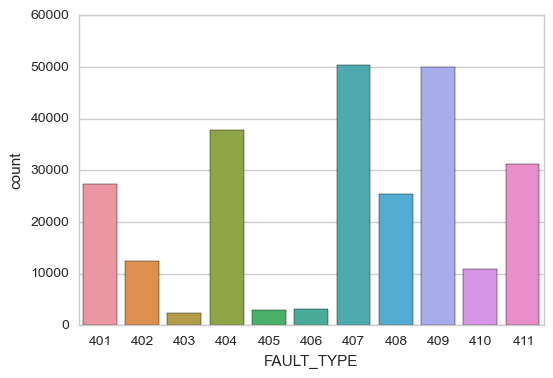

In [7]:
fig, axis0 = plt.subplots(1, 1)
sns.countplot(x='FAULT_TYPE', data=data, ax=axis0)

从故障类型柱状图可以看出故障类型数据不平衡，402-406较少，407-411较多

## SYNC_ORG_NO

In [8]:
#ORG
print data['SYNC_ORG_NO'].describe()
#plot
def plot_fun(name_fea, name_fault, fontsize=None):
    
    fig, axis1 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, data=data, ax = axis1)

    fig, axis2 = plt.subplots(1, 1)
    c = data[name_fea].value_counts()
    s = c.cumsum()/c.sum()
    axis2.plot(np.arange(s.shape[0])+1, s.values*100)
    axis2.set_title('precent of %s'%name_fea)

    fig, axis3 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, hue=name_fault, data=data, ax=axis3)
    plt.legend(loc = 2)

    fig, axis4 = plt.subplots(1, 1)
    sns.countplot(x=name_fault, hue=name_fea, data=data, ax=axis4)
    plt.legend(loc = 2, fontsize=fontsize)

    #calculate similar score
    from scipy.cluster.hierarchy import dendrogram, linkage    
    #clustermap

    fault_num1 = data.groupby([name_fault, name_fea])[data.columns[0]].count().unstack()

    ratio = fault_num1 / fault_num1.sum()  

    g1 = sns.clustermap(ratio, 
                        cmap=plt.get_cmap('RdBu'),
                        vmax=1,
                        vmin=-1,
                        linewidth=0,
                        figsize=(10, 10),
                        row_cluster=False,
                        col_cluster=False
                    )
    plt.title('fault ratio')

#plot
#plot_fun('SYNC_ORG_NO', 'FAULT_TYPE')
#get_dummies
SYNC_ORG_dummies = pd.get_dummies(data['SYNC_ORG_NO'])

#ORG_dummies.drop(['33101', '33407', '33411'], axis=1, inplace=True)

#data = data.join(SYNC_ORG_dummies)

#data.drop(['SYNC_ORG_NO'], axis=1, inplace=True)
#del ORG_dummies

count     253806
unique        15
top        33101
freq       78972
Name: SYNC_ORG_NO, dtype: object


In [9]:

#ORG
data['ORG_NO'].describe()
#plot

#plot
#plot_fun('ORG_NO', 'FAULT_TYPE')
#get_dummies
ORG_freq = data['ORG_NO'].value_counts().index[data['ORG_NO'].value_counts().values<100]
data['ORG_NO'] = data['ORG_NO'].replace(ORG_freq.values, 0)
ORG_dummies = pd.get_dummies(data['ORG_NO'])# 转化为稀疏矩阵
#ORG_dummies.drop(['33101', '33407', '33411'], axis=1, inplace=True)
print ORG_dummies.shape
#data = data.join(ORG_dummies)
#data.drop(['ORG_NO'], axis=1, inplace=True)
#del ORG_dummies

(253806, 424)


## ORG故障类型统计
- 各个地区的故障数量不同，前8个到95%
- 从ORG与FAULT_TYPE统计图可以看出，不同地区的故障类型分布有所不同，所以认为ORG对于FAULT_TYPE类型的识别是有用的。
- 故障类型分布图显示了每个地区的故障类型占比
- 有几个地区故障类型数据较少[33101,33407,33411]，对于故障类型识别用处不大，删除
- 对属性做了二元变换处理

## SPEC_CODE

In [10]:
#SPEC_CODE
data['SPEC_CODE'].describe()

count     253806
unique        35
top          102
freq      122557
Name: SPEC_CODE, dtype: object

In [11]:
data['SPEC_CODE'].value_counts()

102    122557
100     46489
101     30174
118     20878
104      7911
121      5342
112      4417
108      3025
115      2778
106      1834
103      1823
129      1520
113      1364
131       867
125       724
116       450
119       438
123       226
109       216
130       190
107       123
122        98
136        66
138        66
           58
135        48
126        40
139        30
111        23
127        12
141         7
134         7
105         3
140         1
132         1
Name: SPEC_CODE, dtype: int64

In [12]:
spec_freq = data['SPEC_CODE'].value_counts().index[data['SPEC_CODE'].value_counts().values<500]
#spec_mapping = {label:idx for label,idx in zip(spec_freq, np.zeros(len(spec_freq)))}
print spec_freq.values

[u'116' u'119' u'123' u'109' u'130' u'107' u'122' u'136' u'138' u' ' u'135'
 u'126' u'139' u'111' u'127' u'141' u'134' u'105' u'140' u'132']


In [13]:
data['SPEC_CODE'].value_counts()
data['SPEC_CODE'] = data['SPEC_CODE'].replace(spec_freq.values, 0)
print data['SPEC_CODE'].value_counts()

102    122557
100     46489
101     30174
118     20878
104      7911
121      5342
112      4417
108      3025
115      2778
0        2103
106      1834
103      1823
129      1520
113      1364
131       867
125       724
Name: SPEC_CODE, dtype: int64


In [14]:
#plot
#plot_fun('SPEC_CODE', 'FAULT_TYPE')

#get_dummies
SPEC_dummies = pd.get_dummies(data['SPEC_CODE'])

#SPEC_dummies.drop(['103', '121', '129', '131'], axis=1, inplace=True)

#data = data.join(SPEC_dummies)
#data.drop(['SPEC_CODE'], axis=1, inplace=True)


## SPEC_CODE故障类型统计
- SPEC_CODE故障类型同样呈现分布不均匀状态
- 前两类设备类型数据达到98%
- 每种故障类型的SPEC_CODE基本相似
- 故障类型分布图显示了每种SPEC_CODE故障类型占比
- 删除极少出现的SPEC_CODE故障类型
- 对属性进行二元变换

# MANUFACTURER

In [15]:
data['MANUFACTURER'].value_counts()

1118     12048
268      11282
578      10764
10010     9648
1133      9633
1043      9548
10007     8854
10127     8769
417       8480
845       7939
924       7546
965       7383
10001     6562
306       5737
136       5593
588       5200
262       5183
10009     4758
954       4579
1064      4368
719       4200
1077      4181
825       4042
10021     3868
1086      3544
926       3259
21        3123
73        3062
572       2869
557       2865
         ...  
10532       89
1215        86
400         81
10492       60
235         59
1108        55
317         38
834         38
906         31
1111        24
1181        22
10002       22
10756       17
10267        8
204          7
10542        6
10149        5
10428        5
10783        4
10741        3
90           2
10186        2
1155         1
10066        1
10159        1
10008        1
10545        1
10154        1
10787        1
10014        1
Name: MANUFACTURER, dtype: int64

In [16]:
spec_freq = data['MANUFACTURER'].value_counts().index[data['MANUFACTURER'].value_counts().values<500]
data['MANUFACTURER'] = data['MANUFACTURER'].replace(spec_freq.values, 0)
print len(data['MANUFACTURER'].value_counts())

65


In [17]:
#plot
#plot_fun('MANUFACTURER', 'FAULT_TYPE', fontsize=1)
'''
#cluster encoding
from scipy.cluster.hierarchy import fclusterdata
fault_num3 = data.groupby(['FAULT_TYPE', 'MANUFACTURER'])[data.columns[0]].count().unstack()

MAN_ratio = fault_num3 / fault_num3.sum()
MAN_ratio_T = MAN_ratio.T

clusters = fclusterdata(np.array(MAN_ratio_T), 1)
clusters_mapping = {label:idx for label,idx in zip(MAN_ratio.columns, clusters)}


data['MANUFACTURER'] = data['MANUFACTURER'].map(clusters_mapping)
'''
#get_dummies
MAN_dummies = pd.get_dummies(data['MANUFACTURER'])
#data = data.join(MAN_dummies)
#data.drop(['MANUFACTURER'], axis=1, inplace=True)



## MANUFACTURER故障类型统计
- MANUFACTURER故障类型同样呈现分布不均匀状态,浙江省一共有80家供应商，电表数前30家占90%
- 前两类故障类型数据达到98%
- 每种故障类型的供应商分布不同
- 故障类型分布图显示了每种供应商故障类型占比，应用分层聚类方法将具有相似故障类型分布的供应商进行合并
- 对属性进行二元变换

# MONTH

In [18]:
'''
# use month distribution
c1 = data.groupby(['month']).size()
c1.plot(kind='bar', figsize=(12, 6))

c2 = data.groupby(['month', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c2.plot(kind='bar', figsize=(12, 12), subplots=True)

c3 = data.groupby(['month', 'SYNC_ORG_NO']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c3.plot(kind='bar', figsize=(12, 12), subplots=True)
'''

"\n# use month distribution\nc1 = data.groupby(['month']).size()\nc1.plot(kind='bar', figsize=(12, 6))\n\nc2 = data.groupby(['month', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)\nc2.plot(kind='bar', figsize=(12, 12), subplots=True)\n\nc3 = data.groupby(['month', 'SYNC_ORG_NO']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)\nc3.plot(kind='bar', figsize=(12, 12), subplots=True)\n"

## 使用寿命-故障类型统计
- 对浙江省故障电表使用寿命进行了统计，可看出其分布基本为正态分布，符合客观规律。
- 使用寿命-故障类型图显示了每种故障类型的使用寿命分布情况，基本为正态分布，但是其分布参数有所不同，可以用来作为分类特征。
- 使用寿命-供电所分布图，不同供电所的使用寿命分布有区别，可以得出供电所对电表使用寿命有影响。

## FAULT_MONTH

In [19]:
data['FAULT_MONTH'] = pd.Categorical(data['FAULT_MONTH'], ordered=True)

#m1 = data.groupby(['FAULT_MONTH', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.FAULT_MONTH.min(), data.FAULT_MONTH.max()+1)).fillna(0)
#m1.plot(kind='bar', figsize=(12, 12), subplots=True)
#plot_fun('FAULT_MONTH', 'FAULT_TYPE', fontsize=1)
'''
fault_num4 = data.groupby(['FAULT_TYPE', 'FAULT_MONTH'])[data.columns[0]].count().unstack()

FAUMON_ratio = fault_num4 / fault_num4.sum()
FAUMON_ratio_T = FAUMON_ratio.T

clusters = fclusterdata(np.array(FAUMON_ratio_T), 0.70)
clusters = clusters+20
print clusters

clusters_mapping = {label:idx for label,idx in zip(FAUMON_ratio.columns, clusters)}


data['FAULT_MONTH'] = data['FAULT_MONTH'].map(clusters_mapping)
'''
#get_dummies
FAUMON_dummies = pd.get_dummies(data['FAULT_MONTH'])

data['INST_MONTH'] = pd.Categorical(data['INST_MONTH'], ordered=True)
INSMON_dummies = pd.get_dummies(data['INST_MONTH'])
#data = data.join(FAUMON_dummies)
#data.drop(['FAULT_MONTH'], axis=1, inplace=True)
#del fault_num4, FAUMON_ratio, FAUMON_ratio_T, clusters, clusters_mapping, FAUMON_dummies

## 故障月份-故障类型统计
- 故障月份-故障数量统计表显示了不同月份故障数量的分布，分布不是很均匀
- 故障月份-故障类型图显示了每月的故障类型分布情况，每个月的故障类型占比基本相似，是比较弱的分类特征。
- 故障月份-故障类型分布图，不同月份故障类型占比基本相似。

In [20]:
data['COMM_MODE'].value_counts()
#plot_fun('COMM_MODE', 'FAULT_TYPE')
COMM_freq = data['COMM_MODE'].value_counts().index[data['COMM_MODE'].value_counts().values<100]
data['COMM_MODE'] = data['COMM_MODE'].replace(COMM_freq.values, 0)
COMM_dummies = pd.get_dummies(data['COMM_MODE'])# 转化为稀疏矩阵

In [21]:
#整合数据
data.index = range(data.shape[0])
data = data.join(pd.DataFrame(bmat([[SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies]]).toarray()))
data.drop(['FAULT_MONTH','SYNC_ORG_NO', 'ORG_NO', 'SPEC_CODE', 'MANUFACTURER', 'FAULT_TYPE_1', 'FAULT_DATE1', 
           'INST_DATE1', 'COMM_MODE', 'INST_MONTH'], axis=1, inplace=True)

del SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies

In [22]:
data

,FAULT_TYPE,month,0,1,2,3,4,5,6,7,...,549,550,551,552,553,554,555,556,557,558
0,408,39.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,408,17.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,408,25.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,408,22.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,404,18.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,407,47.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,407,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,407,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,407,8.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,404,11.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 机器学习算法故障预测

In [32]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
data_X = data.drop(['FAULT_TYPE'], axis=1)
data_y = data['FAULT_TYPE']
#encode label
le = preprocessing.LabelEncoder()
data_y = le.fit_transform(data_y)
print data_X
data_X1 = coo_matrix(data_X)
train, test, train_y, test_y = train_test_split(data_X1, data_y, test_size=0.33, random_state=27)

        month  0  1  2  3  4  5  6  7  8 ...   549  550  551  552  553  554  \
0        39.0  1  0  0  0  0  0  0  0  0 ...     0    0    1    0    0    0   
1        17.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    1    0    0   
2        25.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    1    0    0   
3        22.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    1    0    0   
4        18.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    1    0    0   
5        47.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    0    0    0   
6         0.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    0    0    0   
7         1.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    0    0    0   
8         8.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    0    0    0   
9        11.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    0    0    0   
10        1.0  1  0  0  0  0  0  0  0  0 ...     0    0    0    0    0    0   
11        3.0  1  0  0  0  0  0  0  0  0 ...     0  

In [33]:
data_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253806 entries, 0 to 253805
Columns: 560 entries, month to 558
dtypes: float64(1), uint8(559)
memory usage: 139.2 MB


# XGBoost

[0]	train-merror:0.590256+0.00433233	test-merror:0.605299+0.00145496
[1]	train-merror:0.567968+0.00213372	test-merror:0.586733+0.000484087
[2]	train-merror:0.559012+0.000729966	test-merror:0.578936+0.00200317
[3]	train-merror:0.554846+0.000947864	test-merror:0.577036+0.0026497
[4]	train-merror:0.551855+0.00155472	test-merror:0.574055+0.00266395
[5]	train-merror:0.548501+0.00165983	test-merror:0.572185+0.00332399
[6]	train-merror:0.545987+0.000592401	test-merror:0.570409+0.00280127
[7]	train-merror:0.54416+0.00093527	test-merror:0.568786+0.0022218
[8]	train-merror:0.54197+0.000516798	test-merror:0.567727+0.00219635
[9]	train-merror:0.541293+0.000338862	test-merror:0.566786+0.00257328
[10]	train-merror:0.540206+0.000488681	test-merror:0.56598+0.00267804
[11]	train-merror:0.53905+0.000369357	test-merror:0.565616+0.00284621
[12]	train-merror:0.537865+0.000421486	test-merror:0.564405+0.00294352
[13]	train-merror:0.536804+0.000855951	test-merror:0.564145+0.00263488
[14]	train-merror:0.53586+

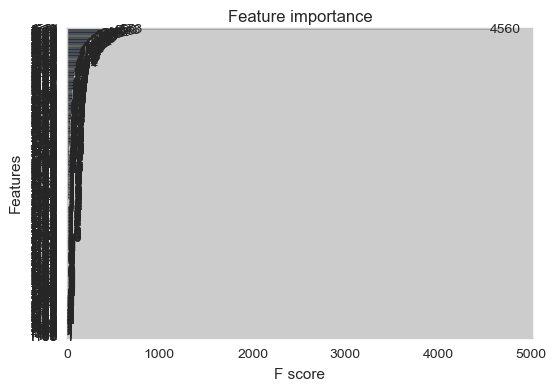

In [24]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

TRAIN = True  #是否训练

#split train set and test set
dtrain = xgb.DMatrix(train, train_y)
dtest = xgb.DMatrix(test)

clf = xgb.XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 20,
    max_depth = 11,
    colsample_bytree = 0.8,
    subsample = 0.9,
    objective = 'multi:softmax',
    min_child_weight = 1,
    gamma = 2,
    seed = 27
    )

param = clf.get_xgb_params()
param['num_class'] = 11
cvresult = xgb.cv(param, dtrain, num_boost_round=20, nfold=3, stratified=True,
                  metrics='merror', early_stopping_rounds=10,verbose_eval=True)

clf.set_params(n_estimators=cvresult.shape[0])   #set n_estimators as cv rounds
if TRAIN:
    clf.fit(train, train_y, eval_metric='merror')
else:
    clf = pickle.load(open("zhejiang_4_all.pkl", "rb"))
        

ypred_xgb = clf.predict(test)
ypred_xgb = le.inverse_transform(ypred_xgb)
test_y_xgb = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_xgb, ypred_xgb))
print(confusion_matrix(test_y_xgb, ypred_xgb))

xgb.plot_importance(clf.booster())
pickle.dump(clf, open("zhejiang_4_all.pkl", "wb"))


* 召回率(Recall)=  系统检索到的相关文件 / 系统所有相关的文件总数
* 准确率(Precision) =  系统检索到的相关文件 / 系统所有检索到的文件总数
* f1 = 2*Recall*Precision / (Recall+Precision)

In [17]:

param_test1 = {'max_depth':range(5,12,2), 'min_child_weight':range(1,7,2)}
gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy',n_jobs=-1,cv=2, verbose=True)
gsearch1.fit(train, train_y)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {'max_depth':range(5,12,2), 'min_child_weight':range(1,7,2)}\ngsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy',n_jobs=-1,cv=2, verbose=True)\ngsearch1.fit(train, train_y)\nprint gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_\n"

In [18]:
data['FAULT_TYPE'].value_counts()

411    54446
408    36046
409    34713
407    17937
410    13939
401    12893
404    10082
402     3422
405     1357
406     1320
403      281
dtype: int64

# SGDClassifier
使用随机梯度下降线性分类器

对于线性不可分情况，使用rbf核将数据映射到高维空间中

In [19]:
from sklearn.kernel_approximation import RBFSampler, Nystroem

USE_RBF = False   #True：RBFSampler, False:Nystroem
if USE_RBF:
    rbf_feature = RBFSampler(gamma=1, random_state=1)
    train_SGD = rbf_feature.fit_transform(train)
    test_SGD = rbf_feature.transform(test)
else:
    Nys_feature = Nystroem(gamma=1, random_state=1)
    train_SGD = Nys_feature.fit_transform(train)
    test_SGD = Nys_feature.transform(test)
        

In [21]:
from sklearn.linear_model import SGDClassifier

USE_GridSearch = False
clf = SGDClassifier(loss='modified_huber', alpha=0.01, n_iter=100, class_weight="balanced", random_state=27)
if USE_GridSearch:
    param_test1 = {'loss':['hinge', 'log','modified_huber', 'squared_hinge', 'perceptron'], 'alpha':[0.1, 0.01, 0.01, 0.0001]}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train_SGD, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train_SGD, train_y)
ypred_sgd = clf.predict(test_SGD)
ypred_sgd = le.inverse_transform(ypred_sgd)
test_y_sgd = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_sgd, ypred_sgd))
print(confusion_matrix(test_y_sgd, ypred_sgd))
pickle.dump(clf, open("zhejiang_4_SGD.pkl", "wb"))

             precision    recall  f1-score   support

        401       0.43      0.00      0.00      4230
        402       0.00      0.00      0.00      1169
        403       0.00      0.00      0.00        99
        404       0.65      0.01      0.01      3337
        405       0.10      0.32      0.15       446
        406       0.02      0.01      0.02       422
        407       0.57      0.01      0.01      5926
        408       0.47      0.07      0.11     11874
        409       0.73      0.08      0.15     11547
        410       0.43      0.04      0.07      4539
        411       0.30      0.93      0.45     17935

avg / total       0.47      0.31      0.19     61524

[[   10     0     0     0   132     4     6    15    11    17  4035]
 [    0     0     0     0    25     0     0     1     2     1  1140]
 [    0     0     0     0     0     0     0     0     0     0    99]
 [    0     0     0    24   163     2     5    80     4    16  3043]
 [    0     0     0     0   141 

## KNN

In [23]:
from sklearn import neighbors

USE_GridSearch = False
n_neighbors = 50
 
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
if USE_GridSearch:
    param_test1 = {'n_neighbors':range(20,60,10), 'weights':['uniform', 'distance']}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train, train_y)
ypred_knn = clf.predict(test)
ypred_knn = le.inverse_transform(ypred_knn)
test_y_knn = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_knn, ypred_knn))
print(confusion_matrix(test_y_knn, ypred_knn))
pickle.dump(clf, open("zhejiang_4_KNN.pkl", "wb"))

             precision    recall  f1-score   support

        401       0.32      0.30      0.31      4230
        402       0.24      0.14      0.17      1169
        403       0.06      0.02      0.03        99
        404       0.34      0.25      0.29      3337
        405       0.34      0.34      0.34       446
        406       0.25      0.15      0.18       422
        407       0.39      0.35      0.37      5926
        408       0.51      0.47      0.49     11874
        409       0.60      0.54      0.57     11547
        410       0.44      0.43      0.44      4539
        411       0.53      0.67      0.59     17935

avg / total       0.49      0.49      0.49     61524

[[ 1289    83     8   167    17    27   455   452   351   424   957]
 [  147   161     2    53     4     9   117   120   110   141   305]
 [    8     1     2     2     0     0    23    10    18    13    22]
 [  263    38     2   830    13    13   378   438   318   224   820]
 [   25     1     1    16   152 

* XGBoost算法使用决策树作为弱分类器，如果训练数据可分的情况下将会一直拟合数据知道训练准确率100%，可以证明数据不可分
* SGDClassifier是针对数据量较大的线性分类器，当线性分类无效时，使用rbf将数据映射到高维空间中，再采用线性分类其进行分类，效果不佳
* 使用KNN算法
## 下一步计划

1. 获取供电所位置坐标信息，将其用于统计基于省、市单位的故障类型分布以及使用寿命热力分布图
2. 调研具有更加有区分度的数据，是否能再现有数据的基础上进行一些变换？
3. 利用挂装量计算未故障电表故障数据，进行电表是否发生故障预测
4. 电表使用寿命作为目标，进行电表使用寿命预测